In [1]:
from sklearn.datasets import make_regression, load_boston
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

In [2]:
X, y = make_regression(n_samples=1000, n_features=10, noise=0.2)
colors = ['red','blue']
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [3]:
def gaussian_kernel(x1, x2, gamma):
    return np.exp(-gamma * LA.norm(x1-x2, axis=-1)**2)

def poly_kernel(x1, x2, degree=3, r=2, gamma=1):
    return (np.dot(x1.T, x2) * gamma + r) ** degree

def sigmoid_kernel(x1, x2, gamma=1, r=1):
    return np.tanh(gamma * np.dot(x1.T, x2) + r)

def laplacian_kernel(x1, x2, gamma):
    return np.exp(-gamma * LA.norm(x1-x2, axis=-1, ord=1))

In [4]:
m,n = X_train.shape
K = np.zeros((m, m))
gamma = 1 / ((X_train.shape[-1]) * X_train.var())
for i, x_i in enumerate(X_train):
    for j, x_j in enumerate(X_train):
        K[i, j] = gaussian_kernel(x_i, x_j, gamma)
K

array([[1.        , 0.02010688, 0.04327068, ..., 0.07667718, 0.09183642,
        0.01880352],
       [0.02010688, 1.        , 0.18268598, ..., 0.04479305, 0.43337584,
        0.22748585],
       [0.04327068, 0.18268598, 1.        , ..., 0.10901388, 0.40106913,
        0.10661195],
       ...,
       [0.07667718, 0.04479305, 0.10901388, ..., 1.        , 0.1052943 ,
        0.05279926],
       [0.09183642, 0.43337584, 0.40106913, ..., 0.1052943 , 1.        ,
        0.32824422],
       [0.01880352, 0.22748585, 0.10661195, ..., 0.05279926, 0.32824422,
        1.        ]])

In [5]:
C = 100
epsilon = 0.1
P = matrix(np.hstack((np.vstack((K, -K)), np.vstack((-K, K)))))
q = matrix(np.vstack(((epsilon+y_train).reshape(y_train.shape[0], 1), (epsilon-y_train).reshape(y_train.shape[0], 1))))
G = matrix(np.vstack((np.eye(2*m)*-1,np.eye(2*m))))
h = matrix(np.hstack((np.zeros(2*m), np.ones(2*m) * C)))
A = matrix(np.hstack((np.ones((1, m)), -np.ones((1, m)))))
b = matrix(0.)

#Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

alphas = alphas.reshape(alphas.shape[0])

     pcost       dcost       gap    pres   dres
 0: -2.1037e+06 -1.6638e+07  3e+07  7e-01  3e-14
 1: -2.0062e+06 -6.4532e+06  4e+06  3e-11  4e-14
 2: -2.3791e+06 -2.9926e+06  6e+05  2e-11  4e-14
 3: -2.5313e+06 -2.6615e+06  1e+05  8e-12  4e-14
 4: -2.5707e+06 -2.5945e+06  2e+04  1e-11  4e-14
 5: -2.5776e+06 -2.5818e+06  4e+03  1e-11  3e-14
 6: -2.5792e+06 -2.5799e+06  7e+02  4e-11  3e-14
 7: -2.5794e+06 -2.5795e+06  1e+02  5e-12  3e-14
 8: -2.5795e+06 -2.5795e+06  9e+00  4e-11  3e-14
 9: -2.5795e+06 -2.5795e+06  4e-01  4e-11  3e-14
Optimal solution found.


In [6]:
alphas_plus = alphas[0:m]
alphas_minus = alphas[m:len(alphas)]

alpha = alphas_minus - alphas_plus

sup_vec_idx = np.argwhere(np.logical_or(alpha > 1e-4, alpha < -1e-4))

X_sup_vec = X_train[sup_vec_idx]
y_sup_vec = y_train[sup_vec_idx]

sup_vec_idx.shape

(800, 1)

In [7]:
y_sup_vec = y_sup_vec.reshape(y_sup_vec.shape[0])
sup_vec_num = sup_vec_idx.shape[0]
pred_mtx = np.zeros(sup_vec_num)
b = 0
for i in range(sup_vec_num):
    for j in range(sup_vec_num):
        pred_mtx[j] = gaussian_kernel(X_sup_vec[j], X_sup_vec[0], gamma)
    b += y_sup_vec[i] - epsilon - np.sum(alpha[sup_vec_idx] * y_sup_vec * pred_mtx)
b /= sup_vec_num
b

-1.3828419481033356

In [8]:
pred = []
for x_test in X_test:
    y_hat = 0
    for (x_train, a) in zip(X_sup_vec, alpha[sup_vec_idx]):
        y_hat += a * gaussian_kernel(x_test, x_train, gamma)
    y_hat += b
    pred.append(y_hat)
pred = np.array(pred)

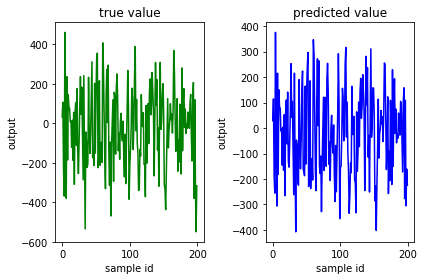

In [9]:
plt.subplot(1, 2, 1)
plt.plot(range(X_test.shape[0]), y_test, c="green")
plt.xlabel("sample id")
plt.ylabel("output")
plt.title("true value")
plt.subplot(1, 2, 2)
plt.plot(range(X_test.shape[0]), pred, c="blue")
plt.xlabel("sample id")
plt.ylabel("output")
plt.title("predicted value")
plt.tight_layout()